# Selecting the best performing classifier with forward selection and PCA 
by Abdallah Daaboul and Jordan Santillo 

### Contents  

**Part 1:** Load and prepare the dataset  
**Part 2:** Binary Classification (class2)  
1. Random forest 
2. SVM 
3. K nearest neighbor 
4. Logistic regression 
5. Naive Bayes
6. Gradient boosting 
**Part 3:** Multiclass Classification (class4) with forward boosting and PCA  
K best  
PCA  
Models  
  
**Part 4:** Predictions  
**Part 5:** Overview and Summary 

## Part 1: Load and prepare the dataset 

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn import decomposition
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from prettytable import PrettyTable
import math
import statistics as stat

### Load the data from Github Repository


In [ ]:
url = "https://raw.githubusercontent.com/AbdallahDaaboul/Project_MachineLearning/main/npf_train.csv"
df_train = pd.read_csv(url)

In [ ]:
url = "https://raw.githubusercontent.com/AbdallahDaaboul/Project_MachineLearning/main/npf_test_hidden.csv"
df_test = pd.read_csv(url)

In [ ]:
df_train.head(3)


,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,PAR.mean,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,1,2000-02-23,nonevent,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,145.160571,2.663504,0.319427,2.695603,0.304894,2.548879,0.382813,2.694138,0.306606,2.771071,0.366386,2.613362,0.348996,81.699876,109.164607,0.319316,0.179649,0.336724,0.183974,0.235517,0.157543,0.332500,0.183478,0.287241,0.172559,0.286638,0.160141,...,339.171515,211.125658,0.000964,0.007481,67.500843,30.529852,95.104103,1.612618,96.532586,2.382040,92.189052,1.781872,96.752672,2.326736,101.351071,4.571036,93.293534,1.981996,84.476919,49.764321,0.559316,0.374688,936.605263,0.916500,-10.272530,1.575415,-10.489828,2.085275,-10.346540,1.347401,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,2,2000-03-25,Ib,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,138.921953,3.253684,0.299728,3.232222,0.308108,3.299150,0.290206,3.228039,0.310416,3.227712,0.307517,3.267582,0.298119,142.534162,115.885107,0.023618,0.040306,0.028105,0.042142,0.025294,0.045379,0.027908,0.046759,0.030458,0.042894,0.025425,0.094298,...,487.596401,268.860550,-0.005340,0.008779,41.090445,21.317089,59.672237,14.625643,60.119150,14.369137,59.535033,15.592649,60.910915,14.122225,62.475294,14.217269,59.184771,15.260717,32.421126,19.516104,0.138289,0.115293,923.450980,2.062171,-1.330589,1.947330,-1.037435,2.231552,-1.738455,1.748079,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,3,2000-04-06,Ib,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,200.826676,4.459042,0.367894,4.422874,0.365105,4.509760,0.360563,4.409401,0.359296,4.395988,0.357929,4.462515,0.362899,156.409709,173.191387,0.030898,0.047893,0.030000,0.046062,0.028802,0.047107,0.024910,0.045468,0.029940,0.052406,0.028802,0.050870,...,515.622611,392.245819,-0.002910,0.006699,41.006814,29.483793,65.047844,13.978114,65.240539,14.181466,64.822395,13.827617,65.872216,14.174827,67.481018,14.652811,64.301856,13.820666,32.940216,25.385709,0.107066,0.122741,923.410714,2.647653,1.672108,1.942941,1.893257,1.960102,1.354012,1.910314,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072


In [ ]:
df_train.isna().sum()  #no missing values.

id             0
date           0
class4         0
partlybad      0
CO2168.mean    0
              ..
UV_A.std       0
UV_B.mean      0
UV_B.std       0
CS.mean        0
CS.std         0
Length: 104, dtype: int64

In [ ]:
df_train.shape #Get the shape of our data

(430, 104)

In [ ]:
df_test.head(3)

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,PAR.mean,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,431,NaN,NaN,False,377.448880,2.920241,377.632640,2.666835,377.908080,3.440430,377.708240,2.543418,210.851946,179.668211,13.516160,0.503071,13.448640,0.496249,13.674790,0.530696,13.394640,0.498479,13.363040,0.497949,13.594444,0.521267,150.196036,150.388580,0.027333,0.059314,0.025333,0.060505,0.013309,0.055271,0.026444,0.060477,0.031630,0.059778,0.012059,0.059952,...,462.288867,395.186100,-0.002204,0.004148,27.684027,24.408845,61.929200,8.972139,62.429200,9.055263,62.922101,9.302637,62.818960,9.081988,63.571440,9.160430,62.301746,9.121943,16.461909,14.679380,0.462741,0.196812,911.833333,24.361855,19.019520,2.306049,19.033461,2.316664,18.649187,2.278480,18.421232,2.267065,19.059027,2.320316,12.572064,9.623161,0.645959,0.558320,0.006159,0.000797
1,432,NaN,NaN,False,369.589091,0.210402,369.632955,0.201409,369.904200,0.252167,369.601600,0.184727,25.017625,15.296680,4.339091,0.035360,4.307045,0.037203,4.376000,0.045535,4.299600,0.034639,4.290400,0.033317,4.334400,0.040816,2.613875,15.499577,0.003396,0.036052,0.016481,0.037121,0.012642,0.075706,0.008519,0.036879,0.018679,0.046162,0.006226,0.049077,...,46.884312,26.235043,0.000000,0.000000,4.799594,3.225846,67.663636,1.291898,68.085682,1.441290,68.073200,1.258270,68.340600,1.344173,69.213400,1.354032,67.448000,1.359301,3.155625,2.131279,0.026038,0.061530,922.333333,0.577350,0.462844,0.194671,0.480250,0.195631,0.178000,0.185177,-0.036312,0.180361,0.476219,0.192571,1.479447,0.640776,0.028665,0.013506,0.000361,0.000031
2,433,NaN,NaN,False,380.338929,0.928028,380.315833,0.917636,380.550119,0.936683,380.301446,0.916970,8.283964,5.107894,6.543333,0.191992,6.497143,0.197768,6.629167,0.184255,6.479639,0.198681,6.528193,0.204993,6.592143,0.181520,11.419841,4.875628,0.009524,0.026155,0.007500,0.027060,0.013810,0.027061,0.011084,0.027542,0.006988,0.023098,0.011429,0.026304,...,18.128247,11.574338,0.000000,0.000000,0.065139,0.646427,92.853214,0.804013,93.415238,0.760399,93.546786,0.760492,93.668072,0.758113,95.544337,1.356642,93.334524,0.738239,0.028685,0.212517,0.112143,0.100697,770.735294,142.420698,1.705657,0.363461,1.790637,0.364509,1.453287,0.372461,1.284980,0.379219,1.737849,0.365878,0.720849,0.427279,0.015179,0.010471,0.002334,0.000347


In [ ]:
df_test.isna().sum()  #no values for date and class4

id               0
date           965
class4         965
partlybad        0
CO2168.mean      0
              ... 
UV_A.std         0
UV_B.mean        0
UV_B.std         0
CS.mean          0
CS.std           0
Length: 104, dtype: int64

In [ ]:
df_test.shape #Get the shape of our data

(965, 104)

### Add class2 column


In [ ]:
df_train["class2"] = df_train["class4"].apply(lambda x: "nonevent" if x == "nonevent" else "event")

In [ ]:
df_train[["class2","class4"]]

,class2,class4
0,nonevent,nonevent
1,event,Ib
2,event,Ib
3,nonevent,nonevent
4,event,II
...,...,...
425,nonevent,nonevent
426,nonevent,nonevent
427,event,Ib
428,nonevent,nonevent


In [ ]:
df_train

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std,class2
0,1,2000-02-23,nonevent,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,145.160571,2.663504,0.319427,2.695603,0.304894,2.548879,0.382813,2.694138,0.306606,2.771071,0.366386,2.613362,0.348996,81.699876,109.164607,0.319316,0.179649,0.336724,0.183974,0.235517,0.157543,0.332500,0.183478,0.287241,0.172559,0.286638,0.160141,...,211.125658,0.000964,0.007481,67.500843,30.529852,95.104103,1.612618,96.532586,2.382040,92.189052,1.781872,96.752672,2.326736,101.351071,4.571036,93.293534,1.981996,84.476919,49.764321,0.559316,0.374688,936.605263,0.916500,-10.272530,1.575415,-10.489828,2.085275,-10.346540,1.347401,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686,nonevent
1,2,2000-03-25,Ib,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,138.921953,3.253684,0.299728,3.232222,0.308108,3.299150,0.290206,3.228039,0.310416,3.227712,0.307517,3.267582,0.298119,142.534162,115.885107,0.023618,0.040306,0.028105,0.042142,0.025294,0.045379,0.027908,0.046759,0.030458,0.042894,0.025425,0.094298,...,268.860550,-0.005340,0.008779,41.090445,21.317089,59.672237,14.625643,60.119150,14.369137,59.535033,15.592649,60.910915,14.122225,62.475294,14.217269,59.184771,15.260717,32.421126,19.516104,0.138289,0.115293,923.450980,2.062171,-1.330589,1.947330,-1.037435,2.231552,-1.738455,1.748079,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210,event
2,3,2000-04-06,Ib,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,200.826676,4.459042,0.367894,4.422874,0.365105,4.509760,0.360563,4.409401,0.359296,4.395988,0.357929,4.462515,0.362899,156.409709,173.191387,0.030898,0.047893,0.030000,0.046062,0.028802,0.047107,0.024910,0.045468,0.029940,0.052406,0.028802,0.050870,...,392.245819,-0.002910,0.006699,41.006814,29.483793,65.047844,13.978114,65.240539,14.181466,64.822395,13.827617,65.872216,14.174827,67.481018,14.652811,64.301856,13.820666,32.940216,25.385709,0.107066,0.122741,923.410714,2.647653,1.672108,1.942941,1.893257,1.960102,1.354012,1.910314,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072,event
3,4,2000-04-11,nonevent,False,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,381.381156,7.208287,68.364653,48.560722,6.613430,0.508011,6.568035,0.498439,6.627225,0.517847,6.579017,0.469558,6.566474,0.454360,6.620694,0.527051,53.752882,44.480753,0.717442,1.046600,0.763642,1.119467,0.601387,0.923043,0.800925,1.168399,0.822428,1.205617,0.663006,0.987611,...,103.352511,-0.000718,0.004928,10.616065,6.538927,90.906221,8.723910,91.022775,8.508574,89.268844,8.521074,91.875780,8.113524,93.993988,7.917405,89.774162,8.896734,11.890787,7.737403,0.323605,0.226767,918.862069,17.331088,2.321829,0.374436,2.610683,0.392255,2.105324,0.338427,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209,nonevent
4,5,2000-04-23,II,False,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,375.337059,2.903780,242.192619,190.952026,7.934171,0.326185,7.882727,0.302425

### Check for correlation 



In [ ]:
# calculate the correlation matrix 
corr = df_train.corr()
# display the correlation matrix
display(corr) 

,id,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,NOx168.mean,NOx168.std,...,PAR.mean,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
id,1.000000,NaN,0.228443,-0.045147,0.229670,-0.043585,0.231927,-0.030203,0.229788,-0.042568,-0.053369,-0.059534,-0.044611,-0.113334,-0.044537,-0.106625,-0.045141,-0.118510,-0.044421,-0.105757,-0.044756,-0.103955,-0.044539,-0.116195,-0.029111,-0.046993,0.021024,0.012831,0.019324,-0.033034,0.028222,0.027789,0.016739,-0.030805,0.016338,-0.020611,0.022843,0.015734,-0.015861,-0.030269,...,-0.038747,-0.046260,-0.024011,-0.135890,-0.070228,-0.084552,0.028028,-0.097316,0.032216,-0.091688,0.026055,-0.105942,0.032004,-0.086588,0.029500,-0.083706,0.027282,-0.098096,-0.053281,-0.068451,0.027422,-0.034811,0.010521,-0.088205,-0.043435,-0.098522,-0.042924,-0.106342,-0.045010,-0.084135,-0.045075,-0.074804,-0.042971,-0.100541,-0.039990,-0.044586,-0.012763,-0.018951,-0.027982,-0.076633
partlybad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CO2168.mean,0.228443,NaN,1.000000,-0.396889,0.999534,-0.386911,0.990738,-0.380015,0.997810,-0.381883,-0.470361,-0.516343,-0.444091,-0.400277,-0.439809,-0.398847,-0.452034,-0.409742,-0.437152,-0.399857,-0.435265,-0.395419,-0.447572,-0.403316,-0.446553,-0.504338,0.356344,0.327890,0.355423,0.326969,0.328038,0.293359,0.344204,0.294911,0.341815,0.314788,0.340702,0.286646,0.406666,0.318581,...,-0.460990,-0.503253,0.140705,-0.303658,-0.355585,-0.444298,0.468207,-0.430023,0.484998,-0.414249,0.455220,-0.465799,0.483552,-0.401395,0.481473,-0.388297,0.459231,-0.447152,-0.014386,-0.106127,0.314747,0.043167,-0.236720,0.055569,-0.581504,-0.386636,-0.581257,-0.410272,-0.582925,-0.378302,-0.582367,-0.382505,-0.581240,-0.397168,-0.486662,-0.510008,-0.487536,-0.500662,-0.120773,-0.121059
CO2168.std,-0.045147,NaN,-0.396889,1.000000,-0.402300,0.993389,-0.332370,0.900384,-0.410831,0.978829,0.297979,0.382078,0.750780,0.522732,0.747667,0.523087,0.755248,0.536171,0.745248,0.531161,0.743139,0.534905,0.753785,0.530436,0.338834,0.377074,-0.127587,-0.071399,-0.131543,-0.069052,-0.078542,0.049552,-0.125948,-0.047260,-0.125230,-0.058830,-0.121561,-0.019488,-0.230797,-0.098305,...,0.324922,0.400603,0.001468,0.276331,0.170094,0.294872,-0.230182,0.341398,-0.246650,0.330927,-0.211054,0.345824,-0.252693,0.320987,-0.259628,0.307950,-0.216773,0.351259,-0.089738,0.002182,-0.129903,-0.012933,0.003614,0.104514,0.660586,0.271731,0.659522,0.280499,0.665943,0.252961,0.668039,0.248533,0.659502,0.282120,0.369696,0.421507,0.470896,0.492944,0.383044,0.326825
CO2336.mean,0.229670,NaN,0.999534,-0.402300,1.000000,-0.391874,0.988514,-0.388099,0.999282,-0.385438,-0.465756,-0.511792,-0.445790,-0.400224,-0.441492,-0.398578,-0.453707,-0.410213,-0.438848,-0.399807,-0.436962,-0.395566,-0.449267,-0.403640,-0.441461,-0.499438,0.354273,0.324564,0.355124,0.325026,0.325797,0.288044,0.344916,0.294558,0.342516,0.314334,0.338663,0.282651,0.402955,0.316292,...,-0.456081,-0.498548,0.120456,-0.308832,-0.352862,-0.441319,0.463324,-0.426003,0.480439,-0.410083,0.450387,-

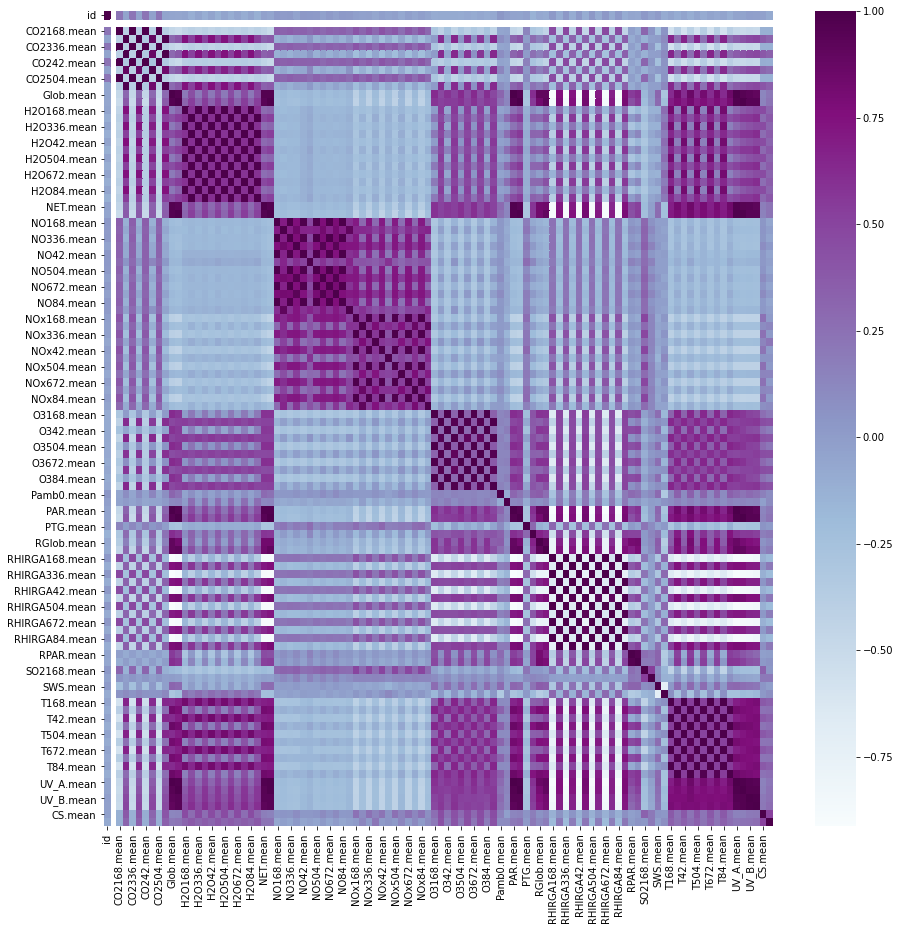

In [ ]:
corr_df = df_train.corr()
corr_best = corr_df.index
plt.figure(figsize=(15,15))
corr_map=sns.heatmap(df_train[corr_best].corr(),annot=False,cmap="BuPu")
plt.savefig('corrmap', format='png')

### Split the train data into training and validation sets


In [ ]:
from sklearn.model_selection import train_test_split

y = df_train["class2"]
X = df_train.drop(["class4","class2","id","date"],axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
X

,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,NOx168.mean,NOx168.std,NOx336.mean,...,PAR.mean,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,False,380.528120,0.802001,380.371466,0.889550,381.816207,1.292593,380.296466,0.968884,236.605353,145.160571,2.663504,0.319427,2.695603,0.304894,2.548879,0.382813,2.694138,0.306606,2.771071,0.366386,2.613362,0.348996,81.699876,109.164607,0.319316,0.179649,0.336724,0.183974,0.235517,0.157543,0.332500,0.183478,0.287241,0.172559,0.286638,0.160141,2.657949,0.672278,2.650259,...,339.171515,211.125658,0.000964,0.007481,67.500843,30.529852,95.104103,1.612618,96.532586,2.382040,92.189052,1.781872,96.752672,2.326736,101.351071,4.571036,93.293534,1.981996,84.476919,49.764321,0.559316,0.374688,936.605263,0.916500,-10.272530,1.575415,-10.489828,2.085275,-10.346540,1.347401,-10.730843,1.381815,-10.282754,1.870056,8.356761,4.534937,0.178084,0.123402,0.002546,0.000686
1,False,373.128684,1.096617,372.980000,1.047750,373.701830,1.259198,372.910000,1.004164,252.480327,138.921953,3.253684,0.299728,3.232222,0.308108,3.299150,0.290206,3.228039,0.310416,3.227712,0.307517,3.267582,0.298119,142.534162,115.885107,0.023618,0.040306,0.028105,0.042142,0.025294,0.045379,0.027908,0.046759,0.030458,0.042894,0.025425,0.094298,0.843355,0.159896,0.829739,...,487.596401,268.860550,-0.005340,0.008779,41.090445,21.317089,59.672237,14.625643,60.119150,14.369137,59.535033,15.592649,60.910915,14.122225,62.475294,14.217269,59.184771,15.260717,32.421126,19.516104,0.138289,0.115293,923.450980,2.062171,-1.330589,1.947330,-1.037435,2.231552,-1.738455,1.748079,-2.095641,1.695622,-1.095864,2.090111,12.906779,7.022300,0.333523,0.239981,0.000662,0.000210
2,False,372.363293,0.626329,372.245689,0.615803,372.847246,0.647279,372.193952,0.596289,269.981547,200.826676,4.459042,0.367894,4.422874,0.365105,4.509760,0.360563,4.409401,0.359296,4.395988,0.357929,4.462515,0.362899,156.409709,173.191387,0.030898,0.047893,0.030000,0.046062,0.028802,0.047107,0.024910,0.045468,0.029940,0.052406,0.028802,0.050870,0.747545,0.207766,0.736407,...,515.622611,392.245819,-0.002910,0.006699,41.006814,29.483793,65.047844,13.978114,65.240539,14.181466,64.822395,13.827617,65.872216,14.174827,67.481018,14.652811,64.301856,13.820666,32.940216,25.385709,0.107066,0.122741,923.410714,2.647653,1.672108,1.942941,1.893257,1.960102,1.354012,1.910314,0.991521,1.914186,1.846503,1.954748,14.286261,9.572444,0.418313,0.344386,0.000541,0.000072
3,False,381.437442,7.281159,381.380405,7.236002,381.926532,7.294374,381.381156,7.208287,68.364653,48.560722,6.613430,0.508011,6.568035,0.498439,6.627225,0.517847,6.579017,0.469558,6.566474,0.454360,6.620694,0.527051,53.752882,44.480753,0.717442,1.046600,0.763642,1.119467,0.601387,0.923043,0.800925,1.168399,0.822428,1.205617,0.663006,0.987611,5.320233,3.781138,5.338671,...,147.485058,103.352511,-0.000718,0.004928,10.616065,6.538927,90.906221,8.723910,91.022775,8.508574,89.268844,8.521074,91.875780,8.113524,93.993988,7.917405,89.774162,8.896734,11.890787,7.737403,0.323605,0.226767,918.862069,17.331088,2.321829,0.374436,2.610683,0.392255,2.105324,0.338427,1.753414,0.340565,2.524931,0.414255,4.945162,3.405652,0.224159,0.192014,0.003710,0.001209
4,False,375.426310,3.264246,375.436524,3.110886,375.740215,3.274924,375.337059,2.903780,242.1

In [ ]:
y

0      nonevent
1         event
2         event
3      nonevent
4         event
         ...   
425    nonevent
426    nonevent
427       event
428    nonevent
429    nonevent
Name: class2, Length: 430, dtype: object

## Part 2: Binary Classification (class2)

### 1. Random forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using Random Forest:', Accuracy, '%')

Accuracy using Random Forest: 0.8837209302325582 %


#### Cross validation


In [ ]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
cv = cross_validate(model, X, y, cv=5)
print(cv['test_score'])
print('CV mean:', cv['test_score'].mean())


[0.87209302 0.8372093  0.90697674 0.89534884 0.88372093]
CV mean: 0.8790697674418604


In [ ]:
cv

{'fit_time': array([2.39680147, 2.59758091, 2.4092412 , 2.39882398, 2.40196157]),
 'score_time': array([0.077492  , 0.08913946, 0.07984233, 0.08653617, 0.07825947]),
 'test_score': array([0.87209302, 0.8372093 , 0.90697674, 0.89534884, 0.88372093])}

### 2. SVM 


In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using SVM:', Accuracy, '%')

Accuracy using SVM: 0.7364341085271318 %


### 3. K nearest neighbour (k=3)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train);
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)
print('Accuracy using 3 Nearest Neighbours:', Accuracy, '%')

Accuracy using 3 Nearest Neighbours: 0.8837209302325582 %


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = logreg_clf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using Logistic Regression:', Accuracy, '%')

Accuracy using Logistic Regression: 0.8682170542635659 %


### 4. Logistic regression

In [ ]:
predictions = logreg_clf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using Logistic Regression:', Accuracy, '%')

Accuracy using Logistic Regression: 0.8682170542635659 %


### 5. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predicitionsNB = gnb.predict(X_val)
Accuracy = sum(predicitionsNB == y_val) / len(y_val)
print('Accuracy using Naive Bayes:', Accuracy, '%')

Accuracy using Naive Bayes: 0.7596899224806202 %


#### Automated TPOT: 
TPOT does the tuning for us, trying out different models and different hyperparameters.

In [ ]:
!pip install tpot
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=3, population_size=3, verbosity=2, max_eval_time_mins=1)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.867103825136612

Generation 2 - Current best internal CV score: 0.867103825136612

Generation 3 - Current best internal CV score: 0.8771584699453552

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=9, min_samples_split=13, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=None, max_eval_time_mins=1, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=3,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [ ]:
#tpotPredictions = tpot.predict(X_val, y_val)
#Accuracy = sum(tpotPredictions == y_val) / len(y_val)
#print('Accuracy using tpot:', Accuracy, '%')

### 6. Gradient boosting

The gradient boosting classifier is not one that we have talked about in class. However, it was very useful in exploring this dataset and performed well against other classifiers. Gradient boosting produces a prediction model in the form of an ensemble of weaker prediction models. It builds this model in steps, generalizing them by allowing the optimization of a differentiable loss function. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBOOSTmodel = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features=0.3, min_samples_leaf=9, min_samples_split=12, n_estimators=100, subsample=1.0)
GBOOSTmodel.fit(X_train,y_train)
predicitionsGBOOST = GBOOSTmodel.predict(X_val)
Accuracy = sum(predicitionsGBOOST == y_val) / len(y_val)
print('Accuracy using GradientBoosting:', Accuracy, '%')

Accuracy using GradientBoosting: 0.9069767441860465 %


#### Perplexity

In [ ]:
# in R: perp <- function(p,y=data_test$y) exp(-mean(log(ifelse(y==1,p,1-p))))

def perp(y): 
  math.exp(-stat.mean(math.log(y))) 

In [ ]:
list = [1, 2, 3]
perp(X_train)

TypeError: ignored

#### Cross validation

In [ ]:
cv = cross_validate(GBOOSTmodel, X, y, cv=5)
print(cv['test_score'])
print('CV mean:', cv['test_score'].mean())

NameError: ignored

In [ ]:
colNames_bin = X.columns
predicitionsTEST = GBOOSTmodel.predict(df_test[colNames_bin])
predicitionsTEST

predictionsTest_prob = predicitionsTEST = GBOOSTmodel.predict_prob(df_test[colNames_bin])

## Part 3: Models for Multiclass Classification (class4) with forward boosting and PCA

### Prepare dataset  

In [ ]:
from sklearn.model_selection import train_test_split

y = df_train["class4"]
X = df_train.drop(["class4","class2","id","date"],axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)


### K Best

In [ ]:

from sklearn.preprocessing import MinMaxScaler

ScaledX = X

# build the scaler model
scaler = MinMaxScaler()# fit using the train set
scaler.fit(X)# transform the test
X_scaled = scaler.transform(X)


In [ ]:
X_scaled.shape

(430, 101)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=20).fit_transform(X_scaled, y)
X_new.shape

(430, 20)

In [ ]:
X_new

array([[0.55150733, 0.45005321, 0.3977923 , ..., 0.0753645 , 0.36205052,
        0.26177986],
       [0.58910155, 0.43044118, 0.42267815, ..., 0.65118395, 0.56640982,
        0.41112005],
       [0.63054695, 0.625048  , 0.63488195, ..., 0.58873745, 0.62836782,
        0.56422951],
       ...,
       [0.69593904, 0.68875742, 0.71615023, ..., 0.54209957, 0.73947074,
        0.68292683],
       [0.01571471, 0.01433313, 0.03562683, ..., 0.03463302, 0.03940765,
        0.0302327 ],
       [0.04796486, 0.04361971, 0.06924125, ..., 0.01086989, 0.07557193,
        0.05601174]])

### PCA


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
fit = pca.fit(X)

print(fit.components_)

[[-8.60943804e-19 -1.43152400e-02  2.80409733e-03 ...  7.44393169e-04
   8.42598717e-07  3.96058720e-07]
 [-4.11661774e-17 -4.08457770e-02  2.32214259e-02 ...  1.01431038e-03
   4.28467848e-06  2.15087986e-06]
 [-1.22667664e-17  5.57286407e-02 -6.95684429e-03 ... -2.65887307e-04
   3.95288157e-08  5.08145646e-07]
 ...
 [ 2.79703890e-16 -2.35853850e-01 -3.82608854e-02 ... -1.29678141e-03
  -1.81546004e-05 -3.22584376e-06]
 [ 3.91091146e-17 -5.31806242e-02  4.72512763e-02 ...  9.96437602e-04
   6.01978920e-05  6.91726251e-06]
 [-4.58120419e-16 -6.48907625e-02 -5.24364056e-02 ... -4.44916928e-04
  -7.09187104e-05 -1.40604761e-05]]


In [ ]:
y

0      nonevent
1            Ib
2            Ib
3      nonevent
4            II
         ...   
425    nonevent
426    nonevent
427          Ib
428    nonevent
429    nonevent
Name: class4, Length: 430, dtype: object

### Collect accuracies after feature selection


In [ ]:
### Function that will be used in order to get accuracies for a model with selected features

In [ ]:
# Build full model with selected features
def GetAccuracies(model,SelectedFeatures):
  clf = model
  feat_cols = SelectedFeatures
  clf.fit(X_train.iloc[:, feat_cols], y_train)

  y_train_pred = clf.predict(X_train.iloc[:, feat_cols])
  TrainAcc = acc(y_train, y_train_pred)

  print('Train Accuracy using RF with forward features selection:',TrainAcc,'%')

  predictions = clf.predict(X_val.iloc[:, feat_cols])# Calculate the absolute errors
  ValAccuracy = sum(predictions == y_val) / len(y_val)

  print('Val Accuracy with forward features selection:',ValAccuracy,'%')

  #Cross Validation
  cv = cross_validate(model, X.iloc[:, feat_cols], y, cv=5)
  print("Cross validation test scores: ",cv['test_score'])
  print('CV mean:', cv['test_score'].mean())
  return ([TrainAcc,ValAccuracy,cv['test_score'].mean()])

### 1. Random forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using Random Forest:', Accuracy, '%')

Accuracy using Random Forest: 0.6434108527131783 %


#### Cross validation


In [ ]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
cv = cross_validate(model, X, y, cv=5)
print(cv['test_score'])
print('CV mean:', cv['test_score'].mean())


[0.62790698 0.65116279 0.68604651 0.6627907  0.6627907 ]
CV mean: 0.6581395348837209


#### Forward features selection 

In [ ]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=7,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:  2.7min finished

[2020-12-06 12:31:25] Features: 1/7 -- score: 0.5446448087431695[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished

[2020-12-06 12:34:04] Features: 2/7 -- score: 0.6545355191256831[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  2.6min finished

[2020-12-06 12:36:40] Features: 3/7 -- score: 0.6776502732240437[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [ ]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(95,)","[0.6065573770491803, 0.5166666666666667, 0.566...",0.544645,"(UV_A.mean,)",0.0620849,0.0483042,0.0241521
2,"(21, 95)","[0.639344262295082, 0.65, 0.75, 0.583333333333...",0.654536,"(H2O84.mean, UV_A.mean)",0.0691079,0.0537683,0.0268841
3,"(21, 75, 95)","[0.7049180327868853, 0.7166666666666667, 0.733...",0.67765,"(H2O84.mean, RHIRGA672.mean, UV_A.mean)",0.0766973,0.0596731,0.0298366
4,"(17, 21, 75, 95)","[0.6721311475409836, 0.7, 0.75, 0.65, 0.666666...",0.68776,"(H2O504.mean, H2O84.mean, RHIRGA672.mean, UV_A...",0.0450353,0.035039,0.0175195
5,"(17, 21, 70, 75, 95)","[0.7213114754098361, 0.75, 0.7166666666666667,...",0.697596,"(H2O504.mean, H2O84.mean, RHIRGA336.std, RHIRG...",0.053794,0.0418536,0.0209268
6,"(17, 21, 25, 70, 75, 95)","[0.7213114754098361, 0.7666666666666667, 0.733...",0.697596,"(H2O504.mean, H2O84.mean, NO168.mean, RHIRGA33...",0.0713893,0.0555433,0.0277716
7,"(17, 18, 21, 25, 70, 75, 95)","[0.7049180327868853, 0.8166666666666667, 0.716...",0.714317,"(H2O504.mean, H2O504.std, H2O84.mean, NO168.me...",0.081513,0.0634199,0.03171


In [ ]:
feat_cols_RF_Forward = list(sfs1.k_feature_idx_)
print(feat_cols_RF_Forward)

[17, 18, 21, 25, 70, 75, 95]


In [ ]:
# Get Accuracy with Forward Selection
RF = RandomForestClassifier(n_estimators=100, random_state=100)
GetAccuracies(RF,feat_cols_RF_Forward)

Train Accuracy using RF with forward features selection: 1.0 %
Val Accuracy with forward features selection: 0.6511627906976745 %
Cross validation test scores:  [0.61627907 0.6627907  0.61627907 0.6744186  0.69767442]
CV mean: 0.6534883720930232


[1.0, 0.6511627906976745, 0.6534883720930232]

### 2. SVM


In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using SVM:', Accuracy, '%')

Accuracy using SVM: 0.5581395348837209 %


#### Forward selection 

In [ ]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build SVM classifier to use in feature selection
clf =  svm.SVC()

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=20,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    3.0s finished

[2020-12-06 12:47:06] Features: 1/20 -- score: 0.5981420765027321[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished

[2020-12-06 12:47:08] Features: 2/20 -- score: 0.6314207650273225[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    2.4s finished

[2020-12-06 12:47:11] Features: 3/20 -- score: 0.6680327868852458[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(72,)","[0.5573770491803278, 0.5833333333333334, 0.533...",0.598142,"(RHIRGA42.std,)",0.0667018,0.0518963,0.0259481
2,"(72, 85)","[0.5737704918032787, 0.7, 0.65, 0.583333333333...",0.631421,"(RHIRGA42.std, T168.mean)",0.0603661,0.0469669,0.0234834
3,"(66, 72, 85)","[0.5901639344262295, 0.7333333333333333, 0.683...",0.668033,"(RGlob.std, RHIRGA42.std, T168.mean)",0.0606165,0.0471617,0.0235808
4,"(66, 72, 78, 85)","[0.5901639344262295, 0.7333333333333333, 0.683...",0.674699,"(RGlob.std, RHIRGA42.std, RHIRGA84.std, T168.m...",0.0597565,0.0464926,0.0232463
5,"(66, 72, 78, 79, 85)","[0.6557377049180327, 0.7, 0.65, 0.633333333333...",0.674481,"(RGlob.std, RHIRGA42.std, RHIRGA84.std, RPAR.m...",0.0472546,0.0367657,0.0183828
6,"(0, 66, 72, 78, 79, 85)","[0.6721311475409836, 0.7166666666666667, 0.65,...",0.67776,"(partlybad, RGlob.std, RHIRGA42.std, RHIRGA84....",0.0549432,0.0427477,0.0213738
7,"(0, 56, 66, 72, 78, 79, 85)","[0.6721311475409836, 0.7166666666666667, 0.65,...",0.67776,"(partlybad, O3672.std, RGlob.std, RHIRGA42.std...",0.0437886,0.034069,0.0170345
8,"(0, 2, 56, 66, 72, 78, 79, 85)","[0.6721311475409836, 0.7166666666666667, 0.633...",0.674426,"(partlybad, CO2168.std, O3672.std, RGlob.std, ...",0.0479227,0.0372855,0.0186427
9,"(0, 2, 54, 56, 66, 72, 78, 79, 85)","[0.6721311475409836, 0.7166666666666667, 0.633...",0.674426,"(partlybad, CO2168.std, O3504.std, O3672.std, ...",0.0479227,0.0372855,0.0186427
10,"(0, 2, 54, 56, 66, 72, 78, 79, 85, 96)","[0.6885245901639344, 0.7166666666666667, 0.633...",0.677705,"(partlybad, CO2168.std, O3504.std, O3672.std, ...",0.048402,0.0376584,0.0188292


In [ ]:
# Get Accuracy with Forward Selection
feat_cols_SVM_Forward = list(sfs1.k_feature_idx_)
SVM_Model = clf =  svm.SVC()
GetAccuracies(SVM_Model,feat_cols_SVM_Forward)

Train Accuracy using RF with forward features selection: 0.6976744186046512 %
Val Accuracy with forward features selection: 0.627906976744186 %
Cross validation test scores:  [0.65116279 0.75581395 0.6744186  0.59302326 0.62790698]
CV mean: 0.6604651162790699


[0.6976744186046512, 0.627906976744186, 0.6604651162790699]

### 3. K nearest neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train);
# predict on the test data
predictions = rf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)
print('Accuracy using 3 Nearest Neighbours:', Accuracy, '%')

Accuracy using 3 Nearest Neighbours: 0.6434108527131783 %


### 4. Logistric regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = logreg_clf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)

print('Accuracy using Logistic Regression:', Accuracy, '%')

Accuracy using Logistic Regression: 0.6434108527131783 %


#### Forward selection 

In [ ]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build Kneighbours classifier to use in feature selection
clf = KNeighborsClassifier(n_neighbors=3)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    2.0s finished

[2020-12-06 12:47:56] Features: 1/5 -- score: 0.5845901639344262[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished

[2020-12-06 12:47:59] Features: 2/5 -- score: 0.6247540983606557[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    2.1s finished

[2020-12-06 12:48:01] Features: 3/5 -- score: 0.6379781420765027[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(69,)","[0.6229508196721312, 0.5833333333333334, 0.516...",0.58459,"(RHIRGA336.mean,)",0.0465611,0.0362261,0.018113
2,"(69, 83)","[0.5737704918032787, 0.5666666666666667, 0.633...",0.624754,"(RHIRGA336.mean, SWS.mean)",0.0638684,0.0496918,0.0248459
3,"(41, 69, 83)","[0.6065573770491803, 0.5666666666666667, 0.633...",0.637978,"(NOx42.mean, RHIRGA336.mean, SWS.mean)",0.0629608,0.0489856,0.0244928
4,"(40, 41, 69, 83)","[0.6065573770491803, 0.5666666666666667, 0.65,...",0.641311,"(NOx336.std, NOx42.mean, RHIRGA336.mean, SWS.m...",0.0631374,0.049123,0.0245615
5,"(0, 40, 41, 69, 83)","[0.6065573770491803, 0.5666666666666667, 0.65,...",0.641311,"(partlybad, NOx336.std, NOx42.mean, RHIRGA336....",0.0631374,0.049123,0.0245615


In [ ]:
# Get Accuracy with Forward Selection
feat_cols_KNegihb_Forward = list(sfs1.k_feature_idx_)
SVM_Model  =  KNeighborsClassifier(n_neighbors=3)
GetAccuracies(SVM_Model,feat_cols_KNegihb_Forward)

Train Accuracy using RF with forward features selection: 0.770764119601329 %
Val Accuracy with forward features selection: 0.5503875968992248 %
Cross validation test scores:  [0.61627907 0.58139535 0.60465116 0.51162791 0.61627907]
CV mean: 0.586046511627907


[0.770764119601329, 0.5503875968992248, 0.586046511627907]

### 5. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predicitionsNB = gnb.predict(X_val)
Accuracy = sum(predicitionsNB == y_val) / len(y_val)
print('Accuracy using Naive Bayes:', Accuracy, '%')

Accuracy using Naive Bayes: 0.4806201550387597 %


#### Forward selection 

In [ ]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build Kneighbours classifier to use in feature selection
clf = GaussianNB()

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=7,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(78,)","[0.5737704918032787, 0.6, 0.5166666666666667, ...",0.594754,"(RHIRGA84.std,)",0.0605751,0.0471295,0.0235647
2,"(78, 79)","[0.5901639344262295, 0.65, 0.5833333333333334,...",0.614699,"(RHIRGA84.std, RPAR.mean)",0.0324293,0.0252311,0.0126156
3,"(78, 79, 99)","[0.6229508196721312, 0.6833333333333333, 0.666...",0.63459,"(RHIRGA84.std, RPAR.mean, CS.mean)",0.0463018,0.0360244,0.0180122
4,"(5, 78, 79, 99)","[0.6721311475409836, 0.65, 0.6166666666666667,...",0.63776,"(CO242.mean, RHIRGA84.std, RPAR.mean, CS.mean)",0.0332777,0.0258911,0.0129456
5,"(5, 63, 78, 79, 99)","[0.6557377049180327, 0.6666666666666666, 0.683...",0.641148,"(CO242.mean, PTG.mean, RHIRGA84.std, RPAR.mean...",0.0466457,0.036292,0.018146
6,"(5, 19, 63, 78, 79, 99)","[0.6721311475409836, 0.7, 0.7, 0.6333333333333...",0.65776,"(CO242.mean, H2O672.mean, PTG.mean, RHIRGA84.s...",0.0572235,0.0445218,0.0222609
7,"(0, 5, 19, 63, 78, 79, 99)","[0.6721311475409836, 0.7, 0.7, 0.6333333333333...",0.65776,"(partlybad, CO242.mean, H2O672.mean, PTG.mean,...",0.0572235,0.0445218,0.0222609


In [ ]:
# Get Accuracy with Forward Selection
feat_cols_NB_Forward = list(sfs1.k_feature_idx_)
NB_Model  =   GaussianNB()
GetAccuracies(NB_Model,feat_cols_NB_Forward)

Train Accuracy using RF with forward features selection: 0.6677740863787376 %
Val Accuracy with forward features selection: 0.627906976744186 %
Cross validation test scores:  [0.61627907 0.59302326 0.62790698 0.58139535 0.54651163]
CV mean: 0.5930232558139534


[0.6677740863787376, 0.627906976744186, 0.5930232558139534]

#### Automated TPOT 
TPOT does the tuning for us, trying out different models and different hyperparameters.

In [ ]:
!pip install tpot
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=3, population_size=3, verbosity=2, max_eval_time_mins=1)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.6610928961748634

Generation 2 - Current best internal CV score: 0.6678688524590164

Generation 3 - Current best internal CV score: 0.6743715846994535

Best pipeline: RandomForestClassifier(ZeroCount(input_matrix), bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=15, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=None, max_eval_time_mins=1, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=3,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [ ]:
tpotPredictions = tpot.predict(X_val, y_val)
Accuracy = sum(tpotPredictions == y_val) / len(y_val)
print('Accuracy using tpot:', Accuracy, '%')

TypeError: ignored

### 6. Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GBOOSTmodel = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features=0.3, min_samples_leaf=9, min_samples_split=12, n_estimators=100, subsample=1.0)
GBOOSTmodel.fit(X_train,y_train)
predicitionsGBOOST = GBOOSTmodel.predict(X_val)
Accuracy = sum(predicitionsGBOOST == y_val) / len(y_val)
print('Accuracy using GradientBoosting:', Accuracy, '%')

Accuracy using GradientBoosting: 0.689922480620155 %


In [ ]:
cv = cross_validate(GBOOSTmodel, X, y, cv=5)
print(cv['test_score'])
print('CV mean:', cv['test_score'].mean())

NameError: ignored

#### Forward selection 

In [ ]:
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build Kneighbours classifier to use in feature selection
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_leaf=9, min_samples_split=12, n_estimators=100, subsample=1.0)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features = 7,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

Features : (1, 7, 17, 51, 68, 74, 96)

In [ ]:

# Get Accuracy with Forward Selection
feat_cols_GradBoost_Forward = list(sfs1.k_feature_idx_)
GradBoost_Model  = GradientBoostingClassifier(learning_rate=0.5, max_depth=5, min_samples_leaf=9, min_samples_split=12, n_estimators=100, subsample=1.0)

GetAccuracies(GradBoost_Model,feat_cols_GradBoost_Forward)

### 7. Linear SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)
predictions = rf.predict(X_val)# Calculate the absolute errors
Accuracy = sum(predictions == y_val) / len(y_val)
print('Accuracy using  Linear SVC:', Accuracy, '%')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



NameError: ignored

## Part 4: Predictions with the Gradient Boosting classifier

Because the gradient boosting classifier performed so well in the tests above, we decided to make our predictions using this model.  

Binary classification accuracy: 0.91  
Multiclass classification accuracy: 0.65  
Multiclass classification with forward selection: 0.70  

### Binary classification prediction 

In [ ]:
#### Abdallah

In [ ]:
colNames = X_train.iloc[:, [1, 7, 17, 51, 68, 74, 96]].columns
df_test[colNames]
predictions = GradBoost_Model.predict(df_test[colNames])# Calculate the absolute errors
predictions[0:10]

array(['nonevent', 'Ia', 'nonevent', 'II', 'Ia', 'Ib', 'nonevent',
       'nonevent', 'II', 'II'], dtype=object)

In [ ]:
df = pd.DataFrame({'Bin':predicitionsTEST, 'Multi':predictions})
df[df.Bin == 'nonevent'][df.Multi != 'nonevent'].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



(42, 2)

In [ ]:
df_test

,id,date,class4,partlybad,CO2168.mean,CO2168.std,CO2336.mean,CO2336.std,CO242.mean,CO242.std,CO2504.mean,CO2504.std,Glob.mean,Glob.std,H2O168.mean,H2O168.std,H2O336.mean,H2O336.std,H2O42.mean,H2O42.std,H2O504.mean,H2O504.std,H2O672.mean,H2O672.std,H2O84.mean,H2O84.std,NET.mean,NET.std,NO168.mean,NO168.std,NO336.mean,NO336.std,NO42.mean,NO42.std,NO504.mean,NO504.std,NO672.mean,NO672.std,NO84.mean,NO84.std,...,PAR.mean,PAR.std,PTG.mean,PTG.std,RGlob.mean,RGlob.std,RHIRGA168.mean,RHIRGA168.std,RHIRGA336.mean,RHIRGA336.std,RHIRGA42.mean,RHIRGA42.std,RHIRGA504.mean,RHIRGA504.std,RHIRGA672.mean,RHIRGA672.std,RHIRGA84.mean,RHIRGA84.std,RPAR.mean,RPAR.std,SO2168.mean,SO2168.std,SWS.mean,SWS.std,T168.mean,T168.std,T42.mean,T42.std,T504.mean,T504.std,T672.mean,T672.std,T84.mean,T84.std,UV_A.mean,UV_A.std,UV_B.mean,UV_B.std,CS.mean,CS.std
0,431,NaN,NaN,False,377.448880,2.920241,377.632640,2.666835,377.908080,3.440430,377.708240,2.543418,210.851946,179.668211,13.516160,0.503071,13.448640,0.496249,13.674790,0.530696,13.394640,0.498479,13.363040,0.497949,13.594444,0.521267,150.196036,150.388580,0.027333,0.059314,0.025333,0.060505,0.013309,0.055271,0.026444,0.060477,0.031630,0.059778,0.012059,0.059952,...,462.288867,395.186100,-0.002204,0.004148,27.684027,24.408845,61.929200,8.972139,62.429200,9.055263,62.922101,9.302637,62.818960,9.081988,63.571440,9.160430,62.301746,9.121943,16.461909,14.679380,0.462741,0.196812,911.833333,24.361855,19.019520,2.306049,19.033461,2.316664,18.649187,2.278480,18.421232,2.267065,19.059027,2.320316,12.572064,9.623161,0.645959,0.558320,0.006159,0.000797
1,432,NaN,NaN,False,369.589091,0.210402,369.632955,0.201409,369.904200,0.252167,369.601600,0.184727,25.017625,15.296680,4.339091,0.035360,4.307045,0.037203,4.376000,0.045535,4.299600,0.034639,4.290400,0.033317,4.334400,0.040816,2.613875,15.499577,0.003396,0.036052,0.016481,0.037121,0.012642,0.075706,0.008519,0.036879,0.018679,0.046162,0.006226,0.049077,...,46.884312,26.235043,0.000000,0.000000,4.799594,3.225846,67.663636,1.291898,68.085682,1.441290,68.073200,1.258270,68.340600,1.344173,69.213400,1.354032,67.448000,1.359301,3.155625,2.131279,0.026038,0.061530,922.333333,0.577350,0.462844,0.194671,0.480250,0.195631,0.178000,0.185177,-0.036312,0.180361,0.476219,0.192571,1.479447,0.640776,0.028665,0.013506,0.000361,0.000031
2,433,NaN,NaN,False,380.338929,0.928028,380.315833,0.917636,380.550119,0.936683,380.301446,0.916970,8.283964,5.107894,6.543333,0.191992,6.497143,0.197768,6.629167,0.184255,6.479639,0.198681,6.528193,0.204993,6.592143,0.181520,11.419841,4.875628,0.009524,0.026155,0.007500,0.027060,0.013810,0.027061,0.011084,0.027542,0.006988,0.023098,0.011429,0.026304,...,18.128247,11.574338,0.000000,0.000000,0.065139,0.646427,92.853214,0.804013,93.415238,0.760399,93.546786,0.760492,93.668072,0.758113,95.544337,1.356642,93.334524,0.738239,0.028685,0.212517,0.112143,0.100697,770.735294,142.420698,1.705657,0.363461,1.790637,0.364509,1.453287,0.372461,1.284980,0.379219,1.737849,0.365878,0.720849,0.427279,0.015179,0.010471,0.002334,0.000347
3,434,NaN,NaN,False,381.047644,1.290080,381.231149,1.245494,381.358678,1.817869,381.290057,1.228278,380.881093,280.914521,4.668851,0.491710,4.614138,0.502501,4.777586,0.471760,4.584253,0.504107,4.575402,0.506836,4.707803,0.477075,258.773200,255.404065,0.023046,0.055061,0.029080,0.057393,0.018161,0.044241,0.028678,0.057390,0.030805,0.104026,0.015145,0.046887,...,737.638006,552.083805,-0.004765,0.011049,44.519942,29.039158,37.320172,14.072622,37.765230,14.381162,38.171149,14.546789,37.941034,14.479086,38.472069,14.667392,37.383699,14.093502,25.116117,18.469726,0.082414,0.091126,921.094919,0.777319,11.050729,3.357004,11.124573,3.594004,10.553749,3.306069,10.298284,3.281097,11.148552,3.478676,19.568691,14.480491,0.783038,0.703191,0.001868,0.000594
4,435,NaN,NaN,False,371.620857,8.552564,371.245461,7.605137,373.101151,10.027695,370.722624,6.804409,130.514702,79.959508,8.012000,0.288332,7.910426,0.297674,8.253669,0.292860,7.840709,0.312222

In [ ]:

predictions = GradBoost_Model.predict(df_test)# Calculate the absolute errors

ValueError: ignored

In [ ]:
##################################################

In [ ]:
#train binary model 
model = GradBoost_Model
model.fit(X_train, y_val["class2"])

#make prediction 
bi_test_prob = pd.DataFrame(model.predict_proba(X_val))
bi_test_cl = pd.DataFrame(model.predict(X_val))
bi_test_pred = pd.merge(bi_test_cl, bi_test_prob, left_index=True, right_index=True)
bi_y = y_val.copy()
bi_test_pred.columns = ["predicted_class", "actual_class", "p(event)", "p(nonevent)"]
numcorrect = bi_test_pred[bi_test_pred["predicted_class"] == bi_test_pred["actual_class"]].shape[0]
print(bi_test_pred)
print("Predicted accuracy:", accuracy_score(y_val["class2"], model.predict(X_val)))
print("Actual accuracy:", numcorrect/y_val.shape[0])

#write to csv 
bi_predict = pd.DataFrame()
bi_predict.to_csv("bi_predict.csv")

KeyError: ignored

### Multiclass classification prediction 

In [ ]:
#train multiclass model 
model = GradBoost_Model
model.fit(X_train, y_val["class2"])

#make prediction 
mu_test_prob = pd.DataFrame(model.predict_proba(X_val))
mu_test_cl = pd.DataFrame(model.predict(X_val))
mu_test_pred = pd.merge(mu_test_cl, mu_test_prob, left_index=True, right_index=True)
mu_y = y_val.copy()
mu-y = mu_y.reset_index()
mu_test_pred.columns = ["predicted_class", "actual_class", "p(event)", "p(nonevent)"]
numcorrect = mu_test_pred[mu_test_pred["predicted_class"] == mu_test_pred["actual_class"]].shape[0]
print(mu_test_pred)
print("Predicted accuracy:", accuracy_score(y_val["class2"], model.predict(X_val)))
print("Actual accuracy:", numcorrect/y_val.shape[0])

#write to csv 
mu_predict = pd.DataFrame()
mu_predict.to_csv("mu_predict.csv")

## Part 5: Overview and Summary

### Overview of our approach  
To build the best classifier for the given dataset, first we had to determine the appropriate learning method to evaluate this specific set of values. We chose supervised learning methods to evaluate. The dataset was split into training and validation sets and run through each of the classifiers twice to obtain their accuracies. The first set of runs used the class2 column to predict events as events or nonevents. The second set used the class4 column. Then we investigated the results of both sets of classifiers and chose the highest performing classifier to make predictions on. After evaluating our predictions, we made conclusions on what we saw.    

### Classification algorithms chosen  
We chose six supervised learning models to test. Five of the models were those talked about in class, and one was a new model. The methods chosen to explore were the random forest model, SVM, 3 nearest neighbor, logistic regerssion, Naive Bayes, and gradient boosting. These 6 classifiers were run twice: once to classify events as "event" or "nonevent," and then to predict each event as one of the four types from the original dataset. After testing the algorithms, we chose gradient boosting to make our predictions on.  

### Steps to select good features and model parameters  
To select the best model parameters, we implemented a Python library that performs automatic machine learning called TPOT. Using a global search proceedure, it can efficiently find the best performing pipeline for the given dataset. In other words, it can do the model tuning for us. TPOT prepares the data and uses a tree-based structure to represent a pipeline including the model parameters. It performs an optimization proceedure to find a tree structure that best performs. The output of TPOT can be implemented in the project script to bypass trial and error of selecting good model features.  

Half of the original dataset is nonevents, therefore a large portion of the test data is nonevents. Because of this, the variance of nonevents differs from other predictors and has the possibility to overshadow other predictors and influence the outcome of a run more effectively. Scaling (normalizing) the data removes this detriment. 

### Summary of results  
The accuracies of all of the classifiers for both class2 and class4 are presented in the table below.  

**class2**  
The classification algorithm with the lowest error is gradient boosting with accuracy of 0.91. The algorithm with the highest error is SVM with accuracy 0.7364. 

**class4**  

**class4 with forward selection**   
Feature selection gave worst accuracy in Kneighbours case. 

In [ ]:
x = PrettyTable()
x.field_names = ["Classifier", "Class2 Accuracy", "Class4 Accuracy", "Class4 Accuracy w/ Forward Selection"]
x.add_row(["Random forest", 0.8837, 0.6434, "-"])
x.add_row(["SVM", 0.7364, 0.5581, 0.6279])
x.add_row(["3-NN", 0.8837, 0.6434, 0.6202])
x.add_row(["Logistic regression", 0.8682, 0.6434, "-"])
x.add_row(["Naive Bayes", 0.7597, 0.4806, 0.5194])
x.add_row(["Gradient boosting", 0.9147, 0.6667, 0.6124])
print(x)

+---------------------+-----------------+-----------------+--------------------------------------+
|      Classifier     | Class2 Accuracy | Class4 Accuracy | Class4 Accuracy w/ Forward Selection |
+---------------------+-----------------+-----------------+--------------------------------------+
|    Random forest    |      0.8837     |      0.6434     |                  -                   |
|         SVM         |      0.7364     |      0.5581     |                0.6279                |
|         3-NN        |      0.8837     |      0.6434     |                0.6202                |
| Logistic regression |      0.8682     |      0.6434     |                  -                   |
|     Naive Bayes     |      0.7597     |      0.4806     |                0.5194                |
|  Gradient boosting  |      0.9147     |      0.6667     |                0.6124                |
+---------------------+-----------------+-----------------+--------------------------------------+


### Insights  
One thing we noticed about the results was that the discriminative models performed significantly better than the generative model. SVM is not really generative or discriminative, and it resulted in an accuracy of 0.7364 on class2, 0.5581 on class4, and 0.6279 with forward selection. For class2: the generative model Naive Bayes, had a low accuracy around that of SVM. For class4 with and without forward selection, SVM's accuracy was even worse. The discriminative models all performed with accuracies in the high 0.80s and low 0.90s for class2 and in the 0.60s for class4. This makes sense because discriminative models are conditional models that are used for regression and classification. The problem to solve for this project was to predict the classification of event type, in which we had to distinguish decision boundaries. Discriminative models are more useful for this task. For class4 this remained true. 

We also see that supervised learning was the better choice to make instead of unsupervised learning methods. We chose to investigate supervised learning methods because we want to find specific relationships and structure in the input data instead of doing a more general analysis. Supervised learning methods are equiped to handle labeled data like our dataset, whereas unsupervised methods produce unlabeled data that the algorithm tries to make sense of. Supervised learning works here because we are able to train the model on data that is already providing the "answer" of its classification. Most of the models selected provided high accuracies that would be practical in the analysis of the dataset.  

There can be a significant difference in the output of a classifier depending on if the data has been normalized or not. When normalized, the data resides in the same range. Unnormalized data can lead to one larger predictor overshadowing others.   

pca  